Authors:

Carmelle Catamura
Shahan Shahad Nawaz
Mudit Mangal

In [ ]:
!pip install mlxtend --upgrade

#### Import libraries and helper functions

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from mlxtend.evaluate import bias_variance_decomp

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

In [ ]:
#mount to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#cwd to where you saved the data
%cd /content/drive/MyDrive/Dataset_New

/content/drive/MyDrive/Dataset_New


In [ ]:
exoplanet = pd.read_csv('kepler_exoplanet_search.csv', comment='#')
exosystems = pd.read_csv('kepler_planetary_system_composite.csv', comment='#')

kepler_exoplanet = pd.read_csv('cumulative_2021.12.10_11.54.27.csv', comment='#')
k2_exoplanet = pd.read_csv('k2pandc_2021.12.10_12.05.25.csv', comment='#')

### Data Cleaning

##### Filtering data

In [ ]:
## Exosystem - check dataset
exosystems.head(5)

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,sy_snum,sy_pnum,sy_mnum,cb_flag,discoverymethod,disc_year,disc_refname,disc_pubdate,disc_locale,disc_facility,disc_telescope,disc_instrument,rv_flag,pul_flag,ptv_flag,tran_flag,ast_flag,obm_flag,micro_flag,etv_flag,ima_flag,dkin_flag,pl_controv_flag,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbper_reflink,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,...,sy_zmagerr2,sy_zmag_reflink,sy_w1mag,sy_w1magerr1,sy_w1magerr2,sy_w1mag_reflink,sy_w2mag,sy_w2magerr1,sy_w2magerr2,sy_w2mag_reflink,sy_w3mag,sy_w3magerr1,sy_w3magerr2,sy_w3mag_reflink,sy_w4mag,sy_w4magerr1,sy_w4magerr2,sy_w4mag_reflink,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,sy_gaiamag_reflink,sy_icmag,sy_icmagerr1,sy_icmagerr2,sy_icmag_reflink,sy_tmag,sy_tmagerr1,sy_tmagerr2,sy_tmag_reflink,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,sy_kepmag_reflink,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,2,1,0,0,Radial Velocity,2007,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,2008-01,Ground,Xinglong Station,2.16 m Telescope,Coude Echelle Spectrograph,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,326.03000,0.32,-0.32,0.0,<a refstr=LIU_ET_AL__2008 href=https://ui.adsa...,1.29,0.05,-0.05,0.0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0.639,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0.732,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,2.358,0.010,-0.010,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,2.270,0.018,-0.018,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,4.44038,0.003848,-0.003848,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,3.83790,0.0071,-0.0071,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,2.0,1.0,2.0,0.0,0.0,0.0
1,2,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,0,0,Radial Velocity,2009,<a refstr=DOLLINGER_ET_AL__2009 href=https://u...,2009-10,Ground,Thueringer Landessternwarte Tautenburg,2.0 m Alfred Jensch Telescope,Coude Echelle Spectrograph,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,516.21997,3.20,-3.20,0.0,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,1.53,0.07,-0.07,0.0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,-0.290,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0.143,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,1.894,0.012,-0.012,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,1.787,0.013,-0.013,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,4.56216,0.003903,-0.003903,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,3.82294,0.0075,-0.0075,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0.0,1.0,1.0,0.0,0.0,0.0
2,3,14 And b,14 And,b,HD 221345,HIP 116076,TIC 333225860,Gaia DR2 1920113512486282240,1,1,0,0,Radial Velocity,2008,<a refstr=SATO_ET_AL__2008 href=https://ui.ads...,2008-12,Ground,Okayama Astrophysical Observatory,1.88 m Telescope,HIDES Echelle Spectrograph,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.84000,0.23,-0.23,0.0,<a refstr=SATO_ET_AL__2008 href=https://ui.ads...,0.83,NaN,NaN,0.0,...,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,1.592,NaN,NaN,<a refstr=CUTRI_ET_AL__2014 href=https://ui.ad...,2.545,0.524,NaN,<a refstr=CUTRI_ET_AL__2014 href=https://ui.ad...,2.719,0.016,NaN,<a refstr=CUTRI_ET_AL__2014 href=https://ui.ad...,2.719,NaN,NaN,<a refstr=CUTRI_ET_AL__2014 href=https://ui.ad...,4.91781,0.002826,-0.002826,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,4.32140,0.0073,-0.0073,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,0.0,1.0,1.0,0.0,0.0,0.

###### Granularity of data - each row represents data for one disovered planet and its parameters, parameters of the star and other properties

In [ ]:
exosystems.disc_facility.value_counts()

Kepler                                   2394
K2                                        425
La Silla Observatory                      247
W. M. Keck Observatory                    177
Multiple Observatories                    158
                                         ... 
Teide Observatory                           1
Atacama Large Millimeter Array (ALMA)       1
KOINet                                      1
Oak Ridge Observatory                       1
Acton Sky Portal Observatory                1
Name: disc_facility, Length: 62, dtype: int64

In [ ]:
# including only K2 and Tess from 2018-21

years = [2018, 2019, 2020, 2021]

exosystems_k2_tess = exosystems.loc[(exosystems['disc_facility'] == 'K2') | (exosystems['disc_facility'] == 'Transiting Exoplanet Survey Satellite (TESS)')]
exosystems_k2_tess = exosystems_k2_tess[exosystems_k2_tess.disc_year.isin(years)]


#encode K2 and TESS to binary
exosystems_k2_tess['disc_facility'] = exosystems_k2_tess.disc_facility.replace({'K2': 'K2', 'Transiting Exoplanet Survey Satellite (TESS)':'TESS'})


In [ ]:
# number of observations TESS (1) vs K2 (0)
exosystems_k2_tess.disc_facility.value_counts()

K2      250
TESS    122
Name: disc_facility, dtype: int64

In [ ]:
# selecting only the relevant features based on description
selected_cols = ['pl_orbper','pl_orbsmax','pl_rade','pl_bmasse','pl_dens','pl_orbeccen','pl_insol',
                 'pl_eqt','pl_orbincl','pl_tranmid','ttv_flag','pl_imppar','pl_trandep','pl_trandur','pl_ratdor',
                 'pl_ratror','pl_occdep','pl_orbtper','pl_orblper','pl_rvamp','pl_projobliq','pl_trueobliq',
                 'st_teff','st_mass','st_rad','st_met','st_lum','st_logg','st_age','st_vsin','st_dens','st_rotp',
                 'sy_dist','sy_pm','sy_plx', 'ra','dec', 'st_nrvc','pl_ntranspec','st_nphot','pl_nespec','st_nspec', 'disc_facility',
                 'pl_name']
k2_v_tess = exosystems_k2_tess[selected_cols]
k2_v_tess.columns # down from 300+ to 44 columns

Index(['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_bmasse', 'pl_dens',
       'pl_orbeccen', 'pl_insol', 'pl_eqt', 'pl_orbincl', 'pl_tranmid',
       'ttv_flag', 'pl_imppar', 'pl_trandep', 'pl_trandur', 'pl_ratdor',
       'pl_ratror', 'pl_occdep', 'pl_orbtper', 'pl_orblper', 'pl_rvamp',
       'pl_projobliq', 'pl_trueobliq', 'st_teff', 'st_mass', 'st_rad',
       'st_met', 'st_lum', 'st_logg', 'st_age', 'st_vsin', 'st_dens',
       'st_rotp', 'sy_dist', 'sy_pm', 'sy_plx', 'ra', 'dec', 'st_nrvc',
       'pl_ntranspec', 'st_nphot', 'pl_nespec', 'st_nspec', 'disc_facility',
       'pl_name'],
      dtype='object')

In [ ]:
k2_v_tess.shape

(372, 44)

##### Missing analysis

In [ ]:
# find columns with NAs in data
k2_v_tess.isna().sum()
# out of 372 these are the number of missings in each columns

pl_orbper          0
pl_orbsmax        85
pl_rade            0
pl_bmasse          1
pl_dens           12
pl_orbeccen      213
pl_insol         220
pl_eqt            91
pl_orbincl        71
pl_tranmid         2
ttv_flag           0
pl_imppar         62
pl_trandep        63
pl_trandur        43
pl_ratdor         45
pl_ratror         23
pl_occdep        372
pl_orbtper       347
pl_orblper       272
pl_rvamp         259
pl_projobliq     371
pl_trueobliq     371
st_teff            0
st_mass            0
st_rad             0
st_met            34
st_lum             0
st_logg            0
st_age           235
st_vsin          223
st_dens            6
st_rotp          302
sy_dist            0
sy_pm              0
sy_plx             3
ra                 0
dec                0
st_nrvc            0
pl_ntranspec       0
st_nphot           0
pl_nespec          0
st_nspec           0
disc_facility      0
pl_name            0
dtype: int64

In [ ]:
# removing columns which are NA across 300+ rows.
# this is done as
remove_cols = ['pl_occdep','pl_orbtper','pl_projobliq',
               'pl_trueobliq','pl_orblper','pl_insol','pl_rvamp',
               'st_age','st_vsin','st_rotp','pl_orbeccen']

k2_v_tess.drop(columns=remove_cols,inplace=True)
k2_v_tess.shape # 32 columns

# check NA in all columns
k2_v_tess.isna().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


pl_orbper         0
pl_orbsmax       85
pl_rade           0
pl_bmasse         1
pl_dens          12
pl_eqt           91
pl_orbincl       71
pl_tranmid        2
ttv_flag          0
pl_imppar        62
pl_trandep       63
pl_trandur       43
pl_ratdor        45
pl_ratror        23
st_teff           0
st_mass           0
st_rad            0
st_met           34
st_lum            0
st_logg           0
st_dens           6
sy_dist           0
sy_pm             0
sy_plx            3
ra                0
dec               0
st_nrvc           0
pl_ntranspec      0
st_nphot          0
pl_nespec         0
st_nspec          0
disc_facility     0
pl_name           0
dtype: int64

In [ ]:
## filling NA with median

col_list = k2_v_tess.columns.to_list()[:-2]

#Group into K2 and TESS discoveries and fill in the remaining NAs with the median value
k2 = k2_v_tess.loc[k2_v_tess['disc_facility'] == 'K2']
tess = k2_v_tess.loc[k2_v_tess['disc_facility'] == 'TESS']

for col in col_list:
  k2[col] = k2[col].fillna(k2[col].median())

for col in col_list:
  tess[col] = tess[col].fillna(tess[col].median())

k2_v_tess = shuffle(pd.concat([k2, tess]))

k2_v_tess.isna().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


pl_orbper        0
pl_orbsmax       0
pl_rade          0
pl_bmasse        0
pl_dens          0
pl_eqt           0
pl_orbincl       0
pl_tranmid       0
ttv_flag         0
pl_imppar        0
pl_trandep       0
pl_trandur       0
pl_ratdor        0
pl_ratror        0
st_teff          0
st_mass          0
st_rad           0
st_met           0
st_lum           0
st_logg          0
st_dens          0
sy_dist          0
sy_pm            0
sy_plx           0
ra               0
dec              0
st_nrvc          0
pl_ntranspec     0
st_nphot         0
pl_nespec        0
st_nspec         0
disc_facility    0
pl_name          0
dtype: int64

#### Outlier Analysis and EDA

In [ ]:
# check column names
k2_v_tess.columns

Index(['pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_bmasse', 'pl_dens', 'pl_eqt',
       'pl_orbincl', 'pl_tranmid', 'ttv_flag', 'pl_imppar', 'pl_trandep',
       'pl_trandur', 'pl_ratdor', 'pl_ratror', 'st_teff', 'st_mass', 'st_rad',
       'st_met', 'st_lum', 'st_logg', 'st_dens', 'sy_dist', 'sy_pm', 'sy_plx',
       'ra', 'dec', 'st_nrvc', 'pl_ntranspec', 'st_nphot', 'pl_nespec',
       'st_nspec', 'disc_facility', 'pl_name'],
      dtype='object')

###### Orbital Period

In [ ]:
k2_v_tess.pl_orbper.describe()

count     372.000000
mean       20.709011
std       189.070858
min         0.280324
25%         3.655970
50%         7.273627
75%        13.906131
max      3650.000000
Name: pl_orbper, dtype: float64

[Text(0.5, 1.0, 'Orbital Period Distribution')]

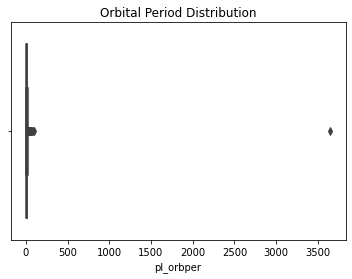

In [ ]:
sns.boxplot(data=k2_v_tess,x="pl_orbper",orient="h").set(title='Orbital Period Distribution')
# remove the extreme point with value 3650 because it is an extreme outlier and prevents other data points to come through

[Text(0.5, 1.0, 'Orbital Period Distribution b/2 Tess and K2')]

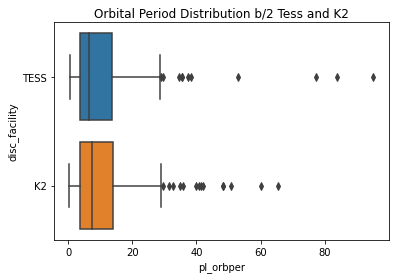

In [ ]:
# plotting again after removing outlier
k2_v_tess_filt=k2_v_tess[~(k2_v_tess['pl_orbper']==3650.0)]
# sns.boxplot(data=k2_v_tess_filt,x="pl_orbper",orient="h").set(title='Orbital Period Distribution')
sns.boxplot(data=k2_v_tess_filt,x="pl_orbper",y="disc_facility",orient="h").set(title='Orbital Period Distribution b/2 Tess and K2')


Text(0.5, 0.98, 'Distribution by Facility')

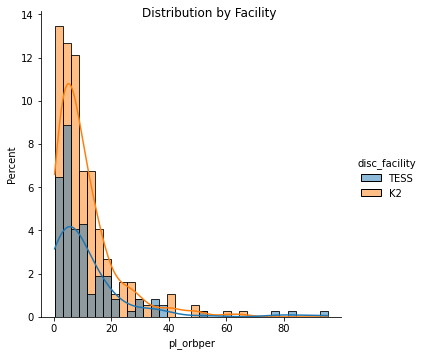

In [ ]:
# checking distribution on histogram
# not removing some points which make the graph right skewed as there seem to be enough such points and generally prove important in defining a planet's characteristics
# since we have only a small number of data points (~320), not trying to remove more "outliers" unless necessary
rel = sns.displot(k2_v_tess_filt, x="pl_orbper", hue="disc_facility",stat='percent',kde=True)
rel.fig.suptitle('Distribution by Facility')


###### Orbit Semi-Major Axis

[Text(0.5, 1.0, 'Orbital Semi-Major Axis Distribution b/2 Tess and K2')]

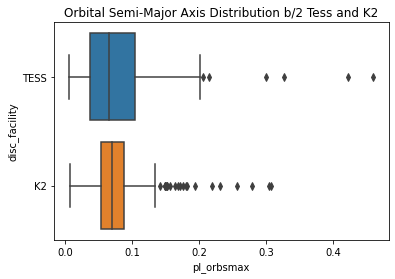

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="pl_orbsmax",y="disc_facility",orient="h").set(title='Orbital Semi-Major Axis Distribution b/2 Tess and K2')


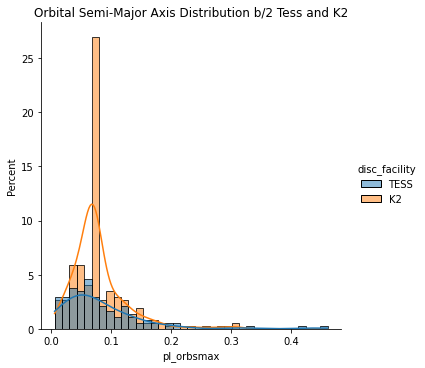

In [ ]:
sns.displot(k2_v_tess_filt, x="pl_orbsmax", hue="disc_facility",stat='percent',kde=True).set(title='Orbital Semi-Major Axis Distribution b/2 Tess and K2')
# both seem right skewed - not major differences in distribution

###### Transit Midpoint

[Text(0.5, 1.0, 'Tansit Midpoint Distribution b/w Tess and K2')]

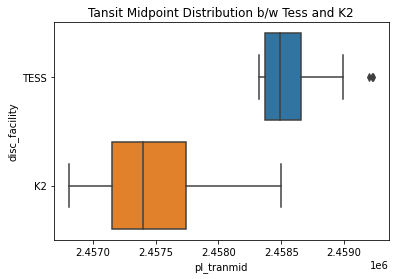

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="pl_tranmid",y="disc_facility",orient="h").set(title='Tansit Midpoint Distribution b/w Tess and K2')
# this variable should be an important predictor in differentiating between Tess and K2
# a clear separation

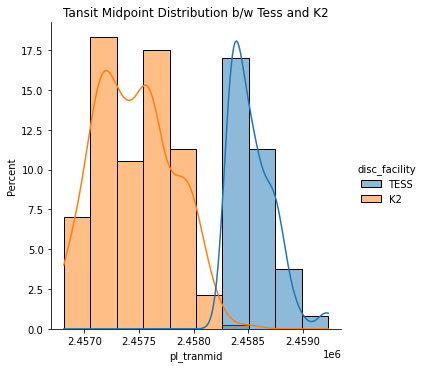

In [ ]:
sns.displot(k2_v_tess_filt, x="pl_tranmid", hue="disc_facility",stat='percent',kde=True).set(title='Tansit Midpoint Distribution b/w Tess and K2')
# there is a clear separation

##### Temperature

[Text(0.5, 1.0, 'Planet Temperature b/w Tess and K2')]

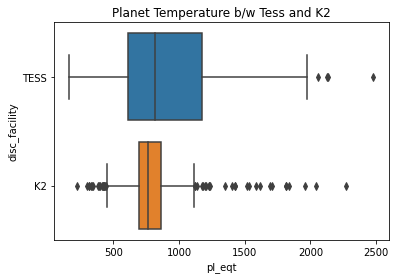

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="pl_eqt",y="disc_facility",orient="h").set(title='Planet Temperature b/w Tess and K2')

Text(0.5, 0.98, 'Planet Temperature b/w Tess and K2')

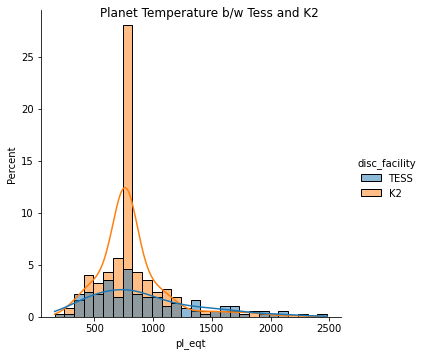

In [ ]:
# sns.histplot(data=k2_v_tess_filt,x="pl_eqt",hue="disc_facility")
rel=sns.displot(k2_v_tess_filt, x="pl_eqt", hue="disc_facility",stat='percent',kde=True)
rel.fig.suptitle('Planet Temperature b/w Tess and K2')
## similar distribution

##### Star Luminosity

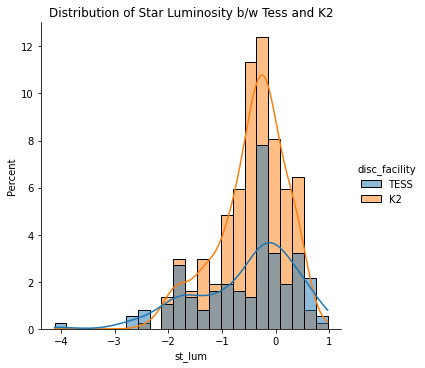

In [ ]:
sns.displot(k2_v_tess_filt, x="st_lum", hue="disc_facility",stat='percent',kde=True).set(title='Distribution of Star Luminosity b/w Tess and K2')
## similar distribution

[Text(0.5, 1.0, 'Distribution of Star Luminosity b/w Tess and K2')]

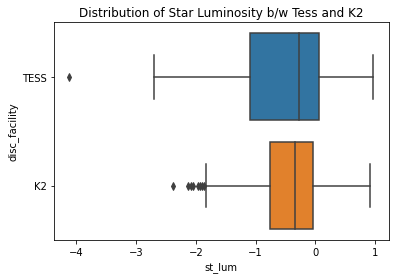

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="st_lum",y="disc_facility",orient="h").set(title='Distribution of Star Luminosity b/w Tess and K2')
## similar overall distribution with similar mean, indicating not much difference in luminosity

##### Planet Radius

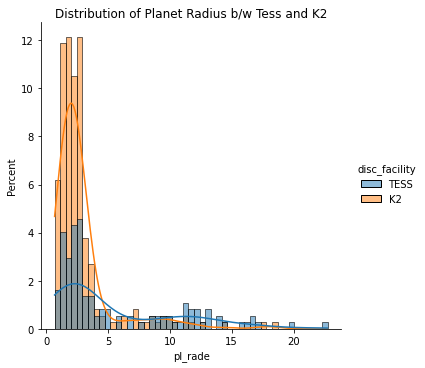

In [ ]:
sns.displot(k2_v_tess_filt, x="pl_rade", hue="disc_facility",stat='percent',kde=True).set(title='Distribution of Planet Radius b/w Tess and K2')
## mean is slightly shifted to the right (for TESS) indicating that planet radius is more in case of TESS

[Text(0.5, 1.0, 'Distribution of Planet Radius b/w Tess and K2')]

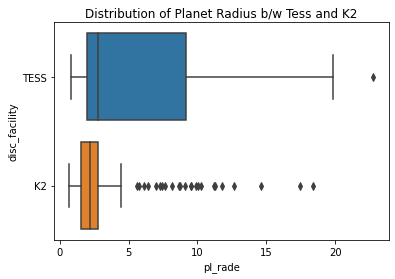

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="pl_rade",y="disc_facility",orient="h").set(title='Distribution of Planet Radius b/w Tess and K2')
## mean is slightly shifted to the right (for TESS) and there is a more broader range towards the right indicating
# that planet radius is generally more in case of TESS

##### Planet density

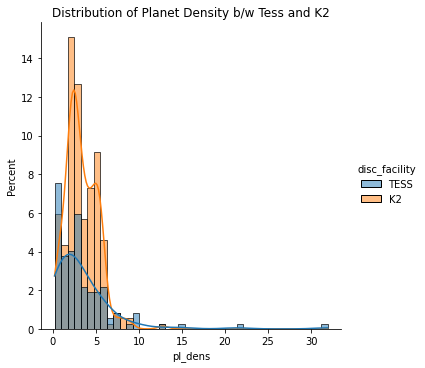

In [ ]:
sns.displot(k2_v_tess_filt, x="pl_dens", hue="disc_facility",stat='percent',kde=True).set(title='Distribution of Planet Density b/w Tess and K2')
## mean is slightly shifted to the left (for TESS)

[Text(0.5, 1.0, 'Distribution of Planet Density b/w Tess and K2')]

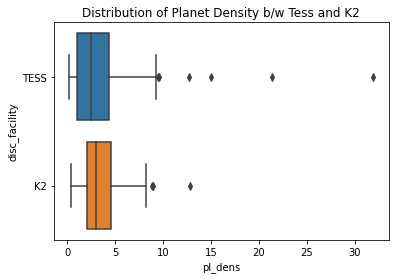

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="pl_dens",y="disc_facility",orient="h").set(title='Distribution of Planet Density b/w Tess and K2')
## similar

##### Planet Mass

[Text(0.5, 1.0, 'Distribution of Planet Mass b/w Tess and K2')]

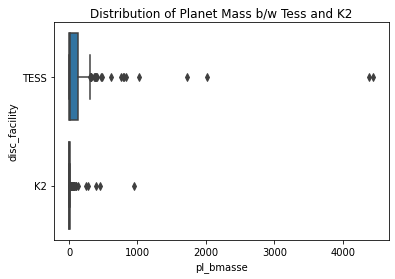

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="pl_bmasse",y="disc_facility",orient="h").set(title='Distribution of Planet Mass b/w Tess and K2')
# has a lot of outliers

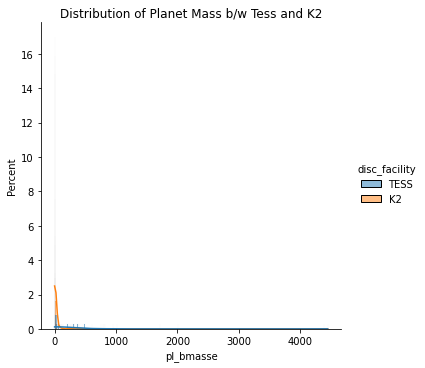

In [ ]:
sns.displot(k2_v_tess_filt, x="pl_bmasse", hue="disc_facility",stat='percent',kde=True).set(title='Distribution of Planet Mass b/w Tess and K2')
# has a lot of outliers so won't be considering this variable
# also descrition says that - "Best planet mass estimate available, in order of preference" so seems to be a mixup of many units and hence not reliable

##### Impact Parameter

In [ ]:
k2_v_tess_filt['pl_imppar'].describe()

count    371.00000
mean       0.44043
std        0.39698
min       -0.01000
25%        0.34000
50%        0.41000
75%        0.46000
max        7.16000
Name: pl_imppar, dtype: float64

In [ ]:
# for which obs is the max value - 7.16
# it is TESS discovery
k2_v_tess_filt[k2_v_tess_filt['pl_imppar'] == 7.16]

,pl_orbper,pl_orbsmax,pl_rade,pl_bmasse,pl_dens,pl_eqt,pl_orbincl,pl_tranmid,ttv_flag,pl_imppar,pl_trandep,pl_trandur,pl_ratdor,pl_ratror,st_teff,st_mass,st_rad,st_met,st_lum,st_logg,st_dens,sy_dist,sy_pm,sy_plx,ra,dec,st_nrvc,pl_ntranspec,st_nphot,pl_nespec,st_nspec,disc_facility,pl_name
4316,1.407941,0.0204,10.4,4386.054,21.4,163.0,88.778,2.458779e+06,0.0,7.16,56.65,0.1333,336.0,7.28,4710.0,0.52,0.01,0.0015,-4.12,7.92,1.83425,24.7359,246.419594,40.3983,284.415675,53.509024,0.0,0.0,0.0,0.0,0.0,TESS,WD 1856+534 b


[Text(0.5, 1.0, 'Distribution of Planet Mass b/w Tess and K2')]

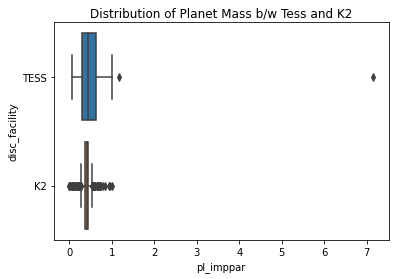

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="pl_imppar",y="disc_facility",orient="h").set(title='Distribution of Planet Mass b/w Tess and K2')
# has a lot of outliers

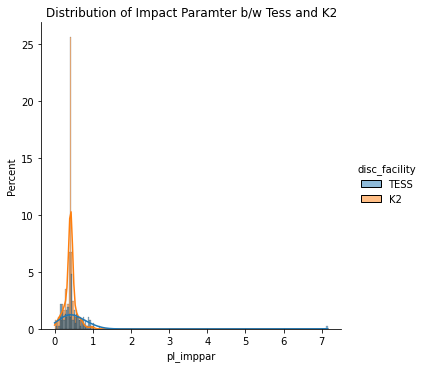

In [ ]:
sns.displot(k2_v_tess_filt, x="pl_imppar", hue="disc_facility",stat='percent',kde=True).set(title='Distribution of Impact Paramter b/w Tess and K2')
# has a lot of outliers so won't be considering this variable

##### Stellar Effective Temperature

[Text(0.5, 1.0, 'Distribution of Planet Mass b/w Tess and K2')]

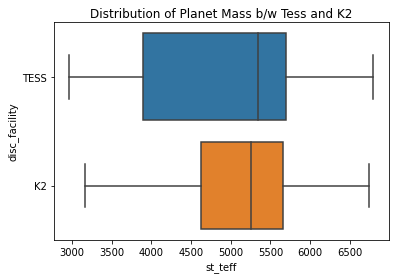

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="st_teff",y="disc_facility",orient="h").set(title='Distribution of Planet Mass b/w Tess and K2')
# similar distributions

##### Ratio of Semi-Major Axis to Stellar Radius

[Text(0.5, 1.0, 'Distribution of Planet RATDOR b/w Tess and K2')]

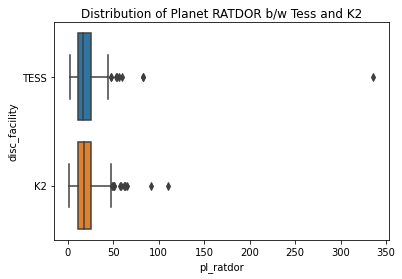

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="pl_ratdor",y="disc_facility",orient="h").set(title='Distribution of Planet RATDOR b/w Tess and K2')
# there is an outlier on the right for TESS but that seems genuine based on the planet analysis so not removed

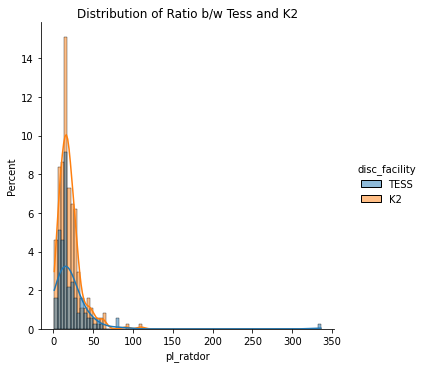

In [ ]:
sns.displot(k2_v_tess_filt, x="pl_ratdor", hue="disc_facility",stat='percent',kde=True).set(title='Distribution of Ratio b/w Tess and K2')
# if we consider this, my not require to have stellar radius and semi-major axis separately

##### Stellar Radius

[Text(0.5, 1.0, 'Distribution of Planet RATDOR b/w Tess and K2')]

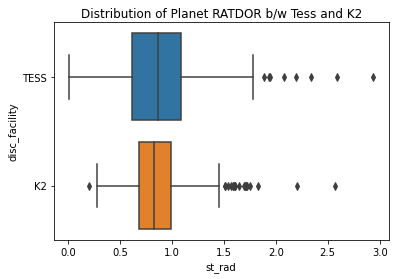

In [ ]:
sns.boxplot(data=k2_v_tess_filt,x="st_rad",y="disc_facility",orient="h").set(title='Distribution of Planet RATDOR b/w Tess and K2')
# there is an outlier on the right for TESS. Can be removed

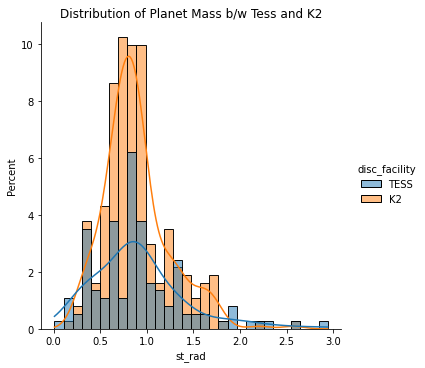

In [ ]:
sns.displot(k2_v_tess_filt, x="st_rad", hue="disc_facility",stat='percent',kde=True).set(title='Distribution of Planet Mass b/w Tess and K2')
# has a lot of outliers so won't be considering this variable

### **Summary of analysis so far:**
1. Transit Midpoint and Planet Radius seem to be good predictors in classifying between TESS discoveries and K2 discoveries
2. Brightness (luminosity of star) doesn't has a similar distribution for both and needs further analysis to confirm if its an important predictor or not.


### EDA and Feature Selection

1. We'll do PCA to see if we can reduce our dimension
2. We'll then do correlation analysis to remove any correlated variables and reduce dimension
3. We'll create more scatterplots on those selected variables and discover some interesting insights

#### PCA for feature selection

In [ ]:
## list of variables filtered to after EDA in the previous step and understanding of variables
list_2= ['pl_orbper', 'pl_rade', 'pl_dens', 'pl_eqt',
       'pl_orbincl', 'pl_tranmid', 'pl_imppar', 'pl_trandep',
       'pl_trandur', 'pl_ratdor', 'st_teff', 'st_mass',
       'st_met', 'st_lum', 'st_logg', 'st_dens', 'sy_dist', 'sy_pm', 'sy_plx',
       'ra', 'dec', 'st_nrvc', 'pl_ntranspec', 'st_nphot', 'pl_nespec',
       'st_nspec', 'disc_facility']

[26.85000035 38.61481139 49.50036681 58.27508281 64.69502387 69.25447781
 73.51202306 76.92996425 80.33821136 83.64412668]


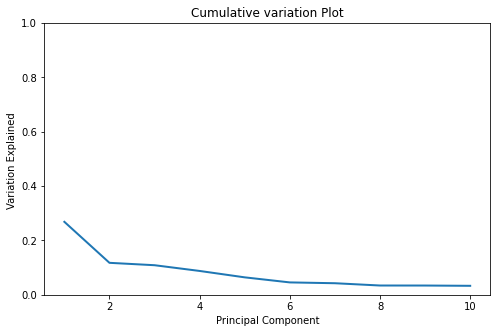

In [ ]:
### PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = list_2[:-1] # only 27 cols
target = k2_v_tess_filt[list_2[-1]]

scaler=StandardScaler()#instantiate
X_scaled=scaler.fit_transform(k2_v_tess_filt.loc[:,features])

pca=PCA(n_components=10)
y_pca=pca.fit_transform(X_scaled)

#print % of variance explained by each component
print(np.cumsum(pca.explained_variance_ratio_)*100)

# generate the Scree plot for PCs
fig = plt.figure(figsize=(8,5))
# plot for forst 10 components
sing_vals = np.arange(10) + 1
#plt.plot(sing_vals, np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.plot(sing_vals, pca.explained_variance_ratio_, linewidth=2)
plt.title('Cumulative variation Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variation Explained ')
plt.ylim(0,1)
plt.show()


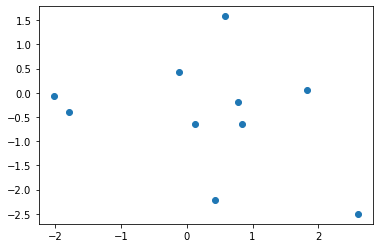

In [ ]:
plt.scatter(y_pca[4],y_pca[5])

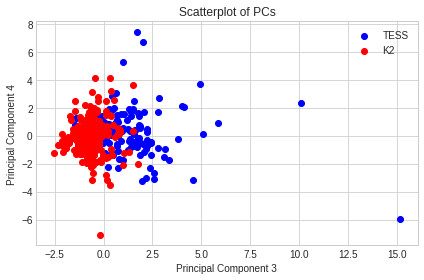

In [ ]:
# scatterplot of PC3 and PC4
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('TESS', 'K2'),
                        ('blue', 'red')):
        plt.scatter(y_pca[target==lab, 2],
                    y_pca[target==lab, 3],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 3')
    plt.ylabel('Principal Component 4')
    plt.legend()
    plt.title("Scatterplot of PCs")
    plt.tight_layout()
    plt.show()

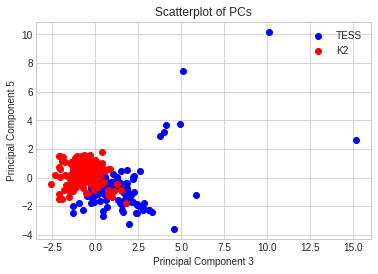

In [ ]:
# scatterplot of PC3 and PC5
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('TESS', 'K2'),
                        ('blue', 'red')):
        plt.scatter(y_pca[target==lab, 2],
                    y_pca[target==lab, 4],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 3')
    plt.ylabel('Principal Component 5')
    plt.legend()
    plt.title("Scatterplot of PCs")
    # plt.tight_layout()
    plt.show()

    # 2 is mst imp (probably trandmid)

#### Finding:
1. PC3 seems to be the only clear component which distinguishes between TESS and K2 and should be representing the "Transit Midpoint" variable which we found to be a very clear separator in EDA previously
2. Instead of a select few variables, we observe that to explain 80% of variance we still need 10 components. 3 variables only cover till 50% variance indicating that we might not be able to do very clear dimension reductionality on this.


#### Correlation Analysis

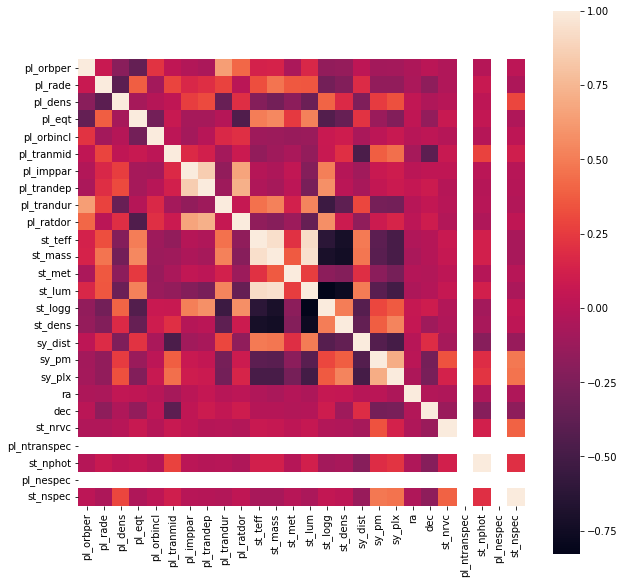

In [ ]:
# Correlation matrix of all the variables together
# This is a large matrix so is not shown in the output but was used to narrow down on variables which had high correlations in next cell
plt.figure(figsize=(10, 10))
k2_v_tess_corr = k2_v_tess_filt[list_2]
cor = k2_v_tess_corr.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map

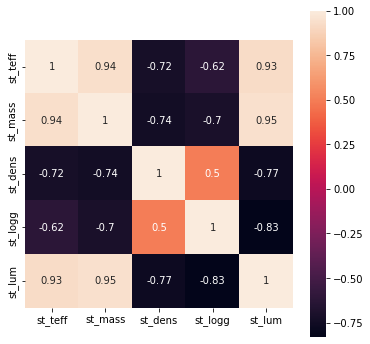

In [ ]:
# plotting correlations of some variables which are highly correlated

plt.figure(figsize=(6, 6))
k2_v_tess_corr = k2_v_tess_filt[['st_teff','st_mass','st_dens','st_logg','st_lum']]
cor = k2_v_tess_corr.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True,annot=True) #Plot the correlation as heat map

## from research - The luminosity and temperature of a main-sequence star are set by its mass. More massive means brighter and hotter.
## Observations: st_teff (temperature) is highly positively correlated to st_mass (mass) and st_lum (luminosity) as expected
## Observations: st_teff (temperature) is also highly negatively correlated to st_dens (density) and st_logg(surface gravity)
## Interpretation: we'll drop st_teff, st_mass, st_dens, st_logg as these are correlated with luminosity
## also didn't give any major indication of being important predictors for classification

In [ ]:
feature_list = list(set(list_2) - set(["st_teff","st_mass","st_dens","st_logg"]))
modeling_df = k2_v_tess_filt[feature_list]
modeling_df.shape ## 23 features in the modeling data

(371, 23)

#### Interesting Insights

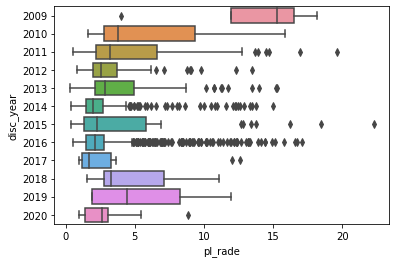

In [ ]:
# radius of earlier discovered planets in Kepler is higher than recently discovered planets
k2_v_tess_check = exosystems.loc[(exosystems['disc_facility'] == 'Kepler')]
sns.boxplot(data=k2_v_tess_check,x="pl_rade",y="disc_year",orient="h")

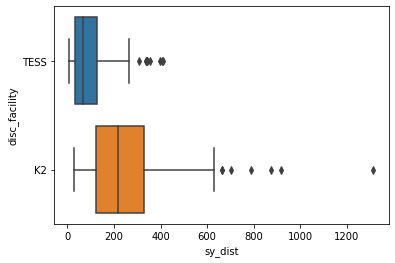

In [ ]:
# TESS observes planets which are closer to earth i.e system distance is less
sns.boxplot(data=k2_v_tess,x="sy_dist",y="disc_facility",orient="h")

##### Transit Midpoint forms a near perfect decision boundary. As was seen in EDA, mean Radius is higher for TESS but doesn't act as a clear decision boundary

Text(0, 0.5, 'Planet Radius')

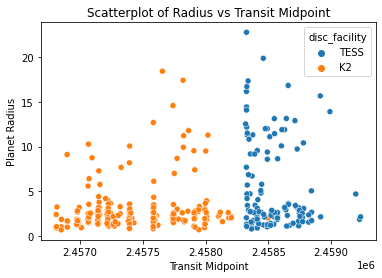

In [ ]:
# Scatterplot of Trand_Mid vs Radius

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = sns.scatterplot(x=modeling_df['pl_tranmid'],y=modeling_df['pl_rade'],
                     hue=modeling_df['disc_facility'],cmap='viridis')

ax.set_title('Scatterplot of Radius vs Transit Midpoint')
ax.set_xlabel('Transit Midpoint')
ax.set_ylabel('Planet Radius')


##### Transit Midpoint forms a near perfect decision boundary. As was seen in EDA, mean Distance is higher for K2 but from scatterplot we don't observe a clear decision boundary

Text(0, 0.5, 'Planetary Distance')

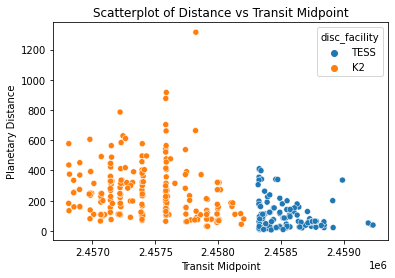

In [ ]:
# Scatterplot of Transit Midpoint vs Distance
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = sns.scatterplot(x=modeling_df['pl_tranmid'],y=modeling_df['sy_dist'],
                     hue=modeling_df['disc_facility'],cmap='viridis')

ax.set_title('Scatterplot of Distance vs Transit Midpoint')
ax.set_xlabel('Transit Midpoint')
ax.set_ylabel('Planetary Distance')


##### Transit Midpoint forms a near perfect decision boundary. We don't observe a clear decision boundary with respect to Star Luminosity though

Text(0, 0.5, 'Star Lumonisity')

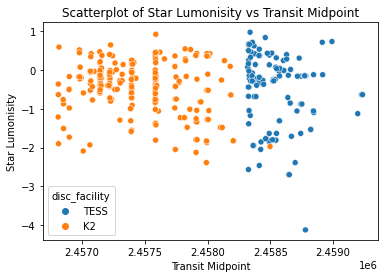

In [ ]:
# Scatterplot of Transit Midpoint vs Star Luminosity
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = sns.scatterplot(x=modeling_df['pl_tranmid'],y=modeling_df['st_lum'],
                     hue=modeling_df['disc_facility'],cmap='viridis')

ax.set_title('Scatterplot of Star Lumonisity vs Transit Midpoint')
ax.set_xlabel('Transit Midpoint')
ax.set_ylabel('Star Lumonisity')


Text(0, 0.5, 'Number of planets')

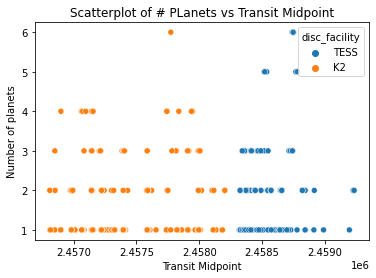

In [ ]:
## Number of Planets in system vs Transit Midpoint

# Scatterplot of Transit Midpoint vs Star Luminosity
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = sns.scatterplot(x=exosystems_k2_tess['pl_tranmid'],y=exosystems_k2_tess['sy_pnum'],
                     hue=exosystems_k2_tess['disc_facility'],cmap='viridis')

ax.set_title('Scatterplot of # PLanets vs Transit Midpoint')
ax.set_xlabel('Transit Midpoint')
ax.set_ylabel('Number of planets')


### Modeling and Inference

In [ ]:
modeling_df.columns

Index(['pl_trandep', 'sy_pm', 'sy_plx', 'pl_orbper', 'pl_orbincl', 'ra',
       'pl_imppar', 'pl_tranmid', 'pl_nespec', 'pl_ratdor', 'st_lum', 'pl_eqt',
       'dec', 'st_nrvc', 'st_met', 'st_nphot', 'disc_facility', 'pl_trandur',
       'st_nspec', 'sy_dist', 'pl_dens', 'pl_ntranspec', 'pl_rade'],
      dtype='object')

In [ ]:
modeling_df.disc_facility.value_counts()

K2      249
TESS    122
Name: disc_facility, dtype: int64

In [ ]:
#encode disc_facility to binary for modeling purposes
modeling_df['disc_facility'] = modeling_df.disc_facility.replace({'K2': 0, 'TESS':1})
modeling_df.disc_facility.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    249
1    122
Name: disc_facility, dtype: int64

#### What type of machine learning problem are you investigating?

Since TESS was designed to discover planets that were brighter and bigger relative to the planets discovered by the K2/Kepler telescope, we would like to investigate the physical differences between planets discovered by both the missions. We do this by building a classification model which predicts whether an exoplanet was discovered by TESS or K2. We will then interpret the roles of the individual features on the predicted 'discovery facility' (TESS or K2).

#### How do you engineer the features for your model? What are the rationales behind selecting these features?

1. The original dataset contained 300+ columns which we bring down to 21 by a combination of removing useless/unnecessary variables, relevance to prediction problem, EDA and correlation analysis [all demonstrated in the *Data Cleaning* and *EDA section*]. We believe these features will be important in describing an exoplanet's properties, including physical properties of a planet itself, its planetary system and its star.
2. The 21 features left are then subjected to further feature selection methods like 'forward selection' (demonstrated below) to give the best set of predictors.

In [ ]:
#Feature selection -- use every feature to train a logistic regression model and
#pick the features with the highest R^2 values. These features are the strongest
#predictors for a linear model.

def variableSelect(my_df, y_var):
  """
  Variable selection
  Run to see which feature is the best predictor/gives the largest R squared value

  Things to consider:
  Do we pick one or multiple features/variables?
  """

  features = list(my_df.columns)
  features.remove(y_var)

  feature_scores = []

  #fit a logistic regression model for each predictor indivdually
  for feature in features:
      x = my_df[[feature]]
      y = my_df[y_var]
      lr = linear_model.LogisticRegression(random_state=0)
      lr.fit(x, y)
      feature_scores.append([feature, lr.score(x,y)])

  return feature_scores

In [ ]:
ranked_scores = variableSelect(modeling_df, 'disc_facility')
ranked_scores = sorted(ranked_scores, key=lambda x: x[1], reverse=True)

for i in ranked_scores:
  print(i[0] +': ', i[1])

dec:  0.876010781671159
sy_plx:  0.816711590296496
sy_pm:  0.7870619946091644
sy_dist:  0.7816711590296496
st_nphot:  0.7628032345013477
pl_rade:  0.7196765498652291
st_nspec:  0.6846361185983828
pl_imppar:  0.6765498652291105
st_nrvc:  0.6765498652291105
pl_ratdor:  0.6738544474393531
pl_eqt:  0.6738544474393531
pl_orbper:  0.6711590296495957
pl_orbincl:  0.6711590296495957
ra:  0.6711590296495957
pl_tranmid:  0.6711590296495957
pl_nespec:  0.6711590296495957
st_lum:  0.6711590296495957
st_met:  0.6711590296495957
pl_trandur:  0.6711590296495957
pl_dens:  0.6711590296495957
pl_ntranspec:  0.6711590296495957
pl_trandep:  0.6684636118598383


In [ ]:
#How many top features should we include?

#split to training and testing data sets
train, test = train_test_split(modeling_df, test_size=0.3, random_state=0)

top_features = [i[0] for i in ranked_scores]

for i in range(1, len(top_features)):

  features = top_features[:i]

  #define train, test sets
  Y_train = train['disc_facility']
  X_train = train[features]

  Y_test = test['disc_facility']
  X_test = test[features]

  #normalize
  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)

  scaler = preprocessing.StandardScaler().fit(X_test)
  X_test = scaler.transform(X_test)

  #predict
  lr = linear_model.LogisticRegression(random_state=0, max_iter=500).fit(X_train, Y_train)
  y_pred = lr.predict(X_test)

  score = accuracy_score(Y_test, y_pred)

  # Reporting FPR and FNR:
  tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()


  tpr = np.round(tp * 1.0 / (tp + fn),2)
  tnr = tn * 1.0 / (tn + fp)
  fpr = fp * 1.0 / (fp + tn)
  fnr = fn * 1.0 / (tp + fn)
  precision = np.round(tp * 1.0 / (tp+fp),2)

  # print('i', i, 'accuracy: ', score, 'fpr: ', fpr, 'fnr: ', fnr, 'tnr: ', tnr, 'recall: ', tpr, 'precision: ', precision)
  print('i', i, 'accuracy: ', score, 'recall: ', tpr, 'precision: ', precision)

i 1 accuracy:  0.8392857142857143 recall:  0.58 precision:  0.92
i 2 accuracy:  0.8660714285714286 recall:  0.63 precision:  0.96
i 3 accuracy:  0.8660714285714286 recall:  0.63 precision:  0.96
i 4 accuracy:  0.8660714285714286 recall:  0.63 precision:  0.96
i 5 accuracy:  0.8660714285714286 recall:  0.66 precision:  0.93
i 6 accuracy:  0.9017857142857143 recall:  0.82 precision:  0.89
i 7 accuracy:  0.9017857142857143 recall:  0.82 precision:  0.89
i 8 accuracy:  0.8928571428571429 recall:  0.79 precision:  0.88
i 9 accuracy:  0.8928571428571429 recall:  0.79 precision:  0.88
i 10 accuracy:  0.8839285714285714 recall:  0.76 precision:  0.88
i 11 accuracy:  0.8928571428571429 recall:  0.79 precision:  0.88
i 12 accuracy:  0.8928571428571429 recall:  0.84 precision:  0.84
i 13 accuracy:  0.8839285714285714 recall:  0.82 precision:  0.84
i 14 accuracy:  0.8928571428571429 recall:  0.84 precision:  0.84
i 15 accuracy:  1.0 recall:  1.0 precision:  1.0
i 16 accuracy:  1.0 recall:  1.0 pre

From the analysis above we should be able to accurately predict most observations in our test set using the **top 16 features**. Using these top features we are optimizing our accuracy, precision, recall metrics.

However, interestingly, 'pl_tranmid' is not a very good predictor even though we found from our EDA that this feature should have a clear linear boundary between K2-discovered and TESS-discovered exoplanets. To investigate this further, we will look at the coefficient and p_values of the features using F-regression.

In [ ]:
#Trying an alternate feature importance analysis
#split to training and testing data sets

train, test = train_test_split(modeling_df, test_size=0.3, random_state=0)

#define train, test sets
Y_train = train['disc_facility']
X_train = train[top_features]

Y_test = test['disc_facility']
X_test = test[top_features]

#normalize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)


def select_features(X_train, Y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, Y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

X_train_fs, X_test_fs, fs = select_features(X_train, Y_train, X_test)
# what are scores for the features

ranked_fs = []
for i in range(len(fs.scores_)):
  ranked_fs.append([top_features[i], fs.scores_[i], fs.pvalues_[i]])

ranked_fs = sorted(ranked_fs, key=lambda x: x[1], reverse=True)


for i in range(len(ranked_fs)):
	print('Feature %s: f-statistic: %f p-val: %f' % (ranked_fs[i][0], ranked_fs[i][1], ranked_fs[i][2]))


Feature st_nrvc: f-statistic: nan p-val: nan
Feature pl_tranmid: f-statistic: 687.111126 p-val: 0.000000
Feature dec: f-statistic: 140.061907 p-val: 0.000000
Feature sy_plx: f-statistic: 70.938443 p-val: 0.000000
Feature sy_dist: f-statistic: 50.779784 p-val: 0.000000
Feature sy_pm: f-statistic: 48.246207 p-val: 0.000000
Feature pl_rade: f-statistic: 32.343696 p-val: 0.000000
Feature st_nphot: f-statistic: 27.202634 p-val: 0.000000
Feature pl_eqt: f-statistic: 10.693408 p-val: 0.001222
Feature pl_imppar: f-statistic: 5.660022 p-val: 0.018087
Feature pl_orbincl: f-statistic: 4.875895 p-val: 0.028118
Feature st_nspec: f-statistic: 4.235333 p-val: 0.040599
Feature ra: f-statistic: 2.986252 p-val: 0.085176
Feature pl_nespec: f-statistic: nan p-val: nan
Feature pl_dens: f-statistic: 1.004906 p-val: 0.317069
Feature st_met: f-statistic: 0.779083 p-val: 0.378247
Feature pl_ratdor: f-statistic: 0.676553 p-val: 0.411539
Feature pl_orbper: f-statistic: 0.333022 p-val: 0.564390
Feature pl_trandur

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


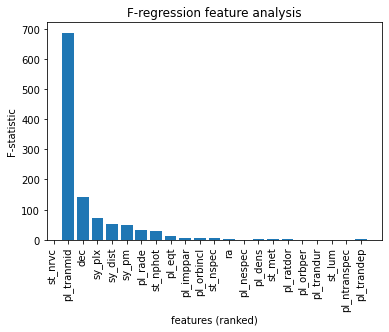

In [ ]:
#plot the F regression scores
plt.bar([i for i in range(len(ranked_fs))], [i[1] for i in ranked_fs])
plt.xticks(ticks=[i for i in range(len(ranked_fs))], labels=[i[0] for i in ranked_fs], rotation=90)
plt.xlabel('features (ranked)')
plt.ylabel('F-statistic')
plt.title('F-regression feature analysis')
plt.show()

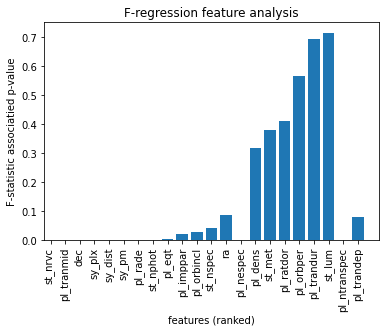

In [ ]:
#plot the F regression scores
plt.bar([i for i in range(len(ranked_fs))], [i[2] for i in ranked_fs])
plt.xticks(ticks=[i for i in range(len(ranked_fs))], labels=[i[0] for i in ranked_fs], rotation=90)
plt.xlabel('features (ranked)')
plt.ylabel('F-statistic associatied p-value')
plt.title('F-regression feature analysis')
plt.show()

From the F-regression feature analysis, pl_transmid is our strongest predictor and is statistically significant. Some of other features, though were somewhat good predictors from the previous analysis don't have any significant relationship with the prediction.

In [ ]:
top_features = [i[0] for i in ranked_fs]

#perform the forward selection again using our new top features

train, test = train_test_split(modeling_df, test_size=0.3, random_state=0)

for i in range(1, len(top_features)):

  features = top_features[:i]

  #define train, test sets
  Y_train = train['disc_facility']
  X_train = train[features]

  Y_test = test['disc_facility']
  X_test = test[features]

  #normalize
  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)

  scaler = preprocessing.StandardScaler().fit(X_test)
  X_test = scaler.transform(X_test)

  #predict
  lr = linear_model.LogisticRegression(random_state=0, max_iter=500).fit(X_train, Y_train)
  y_pred = lr.predict(X_test)

  score = accuracy_score(Y_test, y_pred)

  # Reporting FPR and FNR:
  tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()


  tpr = np.round(tp * 1.0 / (tp + fn),2)
  tnr = tn * 1.0 / (tn + fp)
  fpr = fp * 1.0 / (fp + tn)
  fnr = fn * 1.0 / (tp + fn)
  precision = np.round(tp * 1.0 / (tp+fp),2)

  # print('i', i, 'accuracy: ', score, 'fpr: ', fpr, 'fnr: ', fnr, 'tnr: ', tnr, 'recall: ', tpr, 'precision: ', precision)
  print('i', i, 'accuracy: ', score, 'recall: ', tpr, 'precision: ', precision)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


i 1 accuracy:  0.6607142857142857 recall:  0.0 precision:  nan
i 2 accuracy:  0.9910714285714286 recall:  1.0 precision:  0.97
i 3 accuracy:  1.0 recall:  1.0 precision:  1.0
i 4 accuracy:  1.0 recall:  1.0 precision:  1.0
i 5 accuracy:  1.0 recall:  1.0 precision:  1.0
i 6 accuracy:  1.0 recall:  1.0 precision:  1.0
i 7 accuracy:  1.0 recall:  1.0 precision:  1.0
i 8 accuracy:  1.0 recall:  1.0 precision:  1.0
i 9 accuracy:  1.0 recall:  1.0 precision:  1.0
i 10 accuracy:  1.0 recall:  1.0 precision:  1.0
i 11 accuracy:  1.0 recall:  1.0 precision:  1.0
i 12 accuracy:  1.0 recall:  1.0 precision:  1.0
i 13 accuracy:  1.0 recall:  1.0 precision:  1.0
i 14 accuracy:  1.0 recall:  1.0 precision:  1.0
i 15 accuracy:  1.0 recall:  1.0 precision:  1.0
i 16 accuracy:  1.0 recall:  1.0 precision:  1.0
i 17 accuracy:  1.0 recall:  1.0 precision:  1.0
i 18 accuracy:  1.0 recall:  1.0 precision:  1.0
i 19 accuracy:  1.0 recall:  1.0 precision:  1.0
i 20 accuracy:  1.0 recall:  1.0 precision:  1.

We maximize the performance of our model just by using the **top 2** features!

---



In [ ]:
top_features = top_features[:2]

#### What model do you plan on using and why?

For this classification problem we would like to use a logistic regression model and a random forest classifier and compare their performance. We use logistic regression because it is a simple model with more interpretability. But Logistic regression may suffer from high variance in case of overfitting and hence use of random forest might help us lower that variance

####Logistic Regression

In [ ]:
def model_metrics(Y_train,y_pred):
  tn, fp, fn, tp = confusion_matrix(Y_train, y_pred).ravel()
  accuracy = accuracy_score(Y_train, y_pred)
  recall = tp * 1.0 / (tp + fn)
  tnr = tn * 1.0 / (tn + fp)
  fpr = fp * 1.0 / (fp + tn)
  fnr = fn * 1.0 / (tp + fn)
  precision = tp * 1.0 / (tp+fp)
  f1_score = (2*precision*recall)/(precision+recall)
  return accuracy,precision, recall, f1_score

In [ ]:
#Implement logistic regression without using the results from our feature importance analysis
train, test = train_test_split(modeling_df, test_size=0.3, random_state=0)

#define train, test sets
Y_train = train['disc_facility']
X_train = train.drop(['disc_facility'], axis=1)

Y_test = test['disc_facility']
X_test = test.drop(['disc_facility'], axis=1)

#normalize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

#predict
lr = linear_model.LogisticRegression(random_state=0, max_iter=1500).fit(X_train, Y_train)
y_pred_train = lr.predict(X_train)

# on train data
print("Model Performance Metrics on Training data:")
accuracy,precision, recall, f1_score=model_metrics(Y_train, y_pred_train)
print('Accuracy score: ', lr.score(X_train, Y_train))
print('recall: ', tpr)
print('precision: ', precision)
print('F1 Score: ',f1_score)

## on test data
y_pred = lr.predict(X_test)

print("Model Performance Metrics on Test data:")
accuracy,precision, recall, f1_score=model_metrics(Y_test, y_pred)
print('Accuracy score: ',accuracy)
print('recall: ', tpr)
print('precision: ', precision)
print('F1 Score: ',f1_score)

Model Performance Metrics on Training data:
Accuracy score:  0.9922779922779923
recall:  1.0
precision:  0.9767441860465116
F1 Score:  0.988235294117647
Model Performance Metrics on Test data:
Accuracy score:  1.0
recall:  1.0
precision:  1.0
F1 Score:  1.0


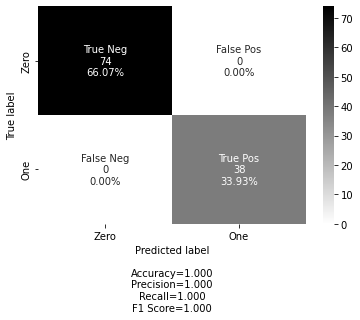

In [ ]:
#print the confusion matrix
cf_matrix=confusion_matrix(Y_test, y_pred)

# print(classification_report(Y_test, y_pred))

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')

In [ ]:
# logistic regression on top 2 features
top_features = top_features[:2]

train, test = train_test_split(modeling_df, test_size=0.3, random_state=0)

#define train, test sets
Y_train = train['disc_facility']
X_train = train[top_features]

Y_test = test['disc_facility']
X_test = test[top_features]

#normalize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

#predict
lr = linear_model.LogisticRegression(random_state=0, max_iter=100).fit(X_train, Y_train)
y_pred_train = lr.predict(X_train)

# on train data
print("Model Performance Metrics on Training data:")
accuracy,precision, recall, f1_score=model_metrics(Y_train, y_pred_train)
print('Accuracy score: ',accuracy)
print('recall: ', tpr)
print('precision: ', precision)
print('F1 Score: ',f1_score)

## on test data
y_pred = lr.predict(X_test)

print("Model Performance Metrics on Test data:")
accuracy,precision, recall, f1_score=model_metrics(Y_test, y_pred)
print('Accuracy score: ',accuracy)
print('recall: ', tpr)
print('precision: ', precision)
print('F1 Score: ',f1_score)

Model Performance Metrics on Training data:
Accuracy score:  0.9884169884169884
recall:  1.0
precision:  0.9655172413793104
F1 Score:  0.9824561403508771
Model Performance Metrics on Test data:
Accuracy score:  0.9910714285714286
recall:  1.0
precision:  0.9743589743589743
F1 Score:  0.9870129870129869


Only using the top 2 features improves our logistic regression model slightly.

Text(0.5, 1.0, 'Confusion Matrix for our final Logistic Regression Classifier')

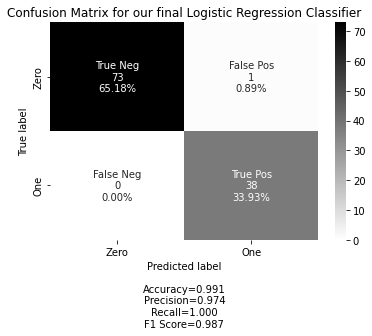

In [ ]:
#print the confusion matrix
cf_matrix=confusion_matrix(Y_test, y_pred)

# print(classification_report(Y_test, y_pred))

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')

plt.title('Confusion Matrix for our final Logistic Regression Classifier')

Our logistic regression model is performing really well. However, we noticed that our dataset is very high in variance. That is, the performance of our model is greatly varies based on the observations selected for the training data set. For this reason, we also want to implement a random forest classifier. At the algorithmic level, random forest classifiers implement a BAGGING approach. The variance of the random forest is smaller compared to the variance of a single decision tree so we want to evaluate how the reduction in variance affects our classification model.

####Random Forest Classifier

In [ ]:
#Try implementing a random forest classifier using ALL features

train, test = train_test_split(modeling_df, test_size=0.3, random_state=0)

#define train, test sets
Y_train = train['disc_facility']
X_train = train.drop(['disc_facility'], axis=1)

Y_test = test['disc_facility']
X_test = test.drop(['disc_facility'], axis=1)

#normalize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

#predict
rf = RandomForestClassifier(random_state=0).fit(X_train, Y_train)
y_pred_train = rf.predict(X_train)

# on train data
print("Model Performance Metrics on Training data:")
accuracy,precision, recall, f1_score=model_metrics(Y_train, y_pred_train)
print('Accuracy score: ',accuracy)
print('recall: ', tpr)
print('precision: ', precision)
print('F1 Score: ',f1_score)

## on test data
y_pred = rf.predict(X_test)

print("Model Performance Metrics on Test data:")
accuracy,precision, recall, f1_score=model_metrics(Y_test, y_pred)
print('Accuracy score: ',accuracy)
print('recall: ', tpr)
print('precision: ', precision)
print('F1 Score: ',f1_score)

Model Performance Metrics on Training data:
Accuracy score:  1.0
recall:  1.0
precision:  1.0
F1 Score:  1.0
Model Performance Metrics on Test data:
Accuracy score:  1.0
recall:  1.0
precision:  1.0
F1 Score:  1.0


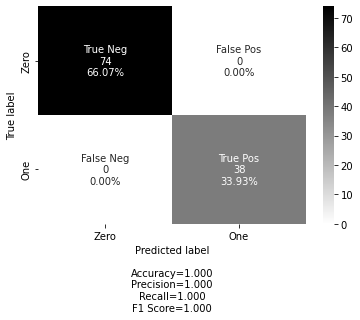

In [ ]:
#print the confusion matrix
cf_matrix=confusion_matrix(Y_test, y_pred)

# print(classification_report(Y_test, y_pred))

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')

To figure out which variable is the most important in these predictions, we do the feature importance analysis.

Text(0.5, 1.0, 'Feature Permutation Importance Scores')

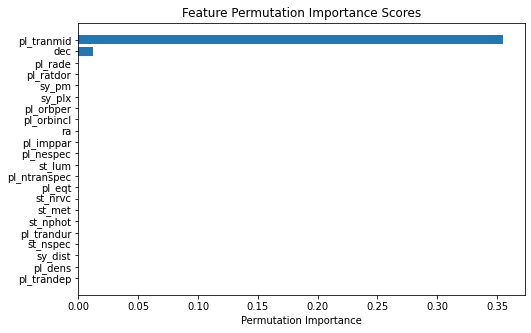

In [ ]:
#Perform a feature importance analysis on the random forest classifier using a
#permutation analysis

features = list(modeling_df.columns)
features.remove('disc_facility')
perm_importance = permutation_importance(rf, X_test, Y_test)

plt.figure(figsize=[8,5])
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(np.asarray(features)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title('Feature Permutation Importance Scores')

As seen before, our planet transit midpoint (pl_tranmid) is a very good predictor between K2-discovered and TESS-discovered planets.

In [ ]:
ranked_perm = np.asarray(features)[sorted_idx]
ranked_perm = ranked_perm[::-1]

#How many top features should we include?

#split to training and testing data sets
train, test = train_test_split(modeling_df, test_size=0.3, random_state=0)

top_features = ranked_perm

for i in range(1, len(top_features)):

  features = top_features[:i]

  #define train, test sets
  Y_train = train['disc_facility']
  X_train = train[features]

  Y_test = test['disc_facility']
  X_test = test[features]

  #normalize
  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)

  scaler = preprocessing.StandardScaler().fit(X_test)
  X_test = scaler.transform(X_test)

  #predict
  rf = RandomForestClassifier(random_state=0).fit(X_train, Y_train)
  y_pred = rf.predict(X_test)

  score = accuracy_score(Y_test, y_pred)

  # Reporting FPR and FNR:
  tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()


  tpr = np.round(tp * 1.0 / (tp + fn),2)
  tnr = tn * 1.0 / (tn + fp)
  fpr = fp * 1.0 / (fp + tn)
  fnr = fn * 1.0 / (tp + fn)
  precision = np.round(tp * 1.0 / (tp+fp),2)

  # print('i', i, 'accuracy: ', score, 'fpr: ', fpr, 'fnr: ', fnr, 'tnr: ', tnr, 'recall: ', tpr, 'precision: ', precision)
  print('i', i, 'accuracy: ', score, 'recall: ', tpr, 'precision: ', precision)

i 1 accuracy:  1.0 recall:  1.0 precision:  1.0
i 2 accuracy:  1.0 recall:  1.0 precision:  1.0
i 3 accuracy:  0.9821428571428571 recall:  1.0 precision:  0.95
i 4 accuracy:  1.0 recall:  1.0 precision:  1.0
i 5 accuracy:  1.0 recall:  1.0 precision:  1.0
i 6 accuracy:  1.0 recall:  1.0 precision:  1.0
i 7 accuracy:  1.0 recall:  1.0 precision:  1.0
i 8 accuracy:  1.0 recall:  1.0 precision:  1.0
i 9 accuracy:  1.0 recall:  1.0 precision:  1.0
i 10 accuracy:  0.9910714285714286 recall:  1.0 precision:  0.97
i 11 accuracy:  1.0 recall:  1.0 precision:  1.0
i 12 accuracy:  1.0 recall:  1.0 precision:  1.0
i 13 accuracy:  0.9910714285714286 recall:  1.0 precision:  0.97
i 14 accuracy:  0.9910714285714286 recall:  1.0 precision:  0.97
i 15 accuracy:  1.0 recall:  1.0 precision:  1.0
i 16 accuracy:  1.0 recall:  1.0 precision:  1.0
i 17 accuracy:  1.0 recall:  1.0 precision:  1.0
i 18 accuracy:  0.9910714285714286 recall:  1.0 precision:  0.97
i 19 accuracy:  1.0 recall:  1.0 precision:  1.

Similar to our logistic regeression model, the random forest classifier performs the best using the top 2 features!

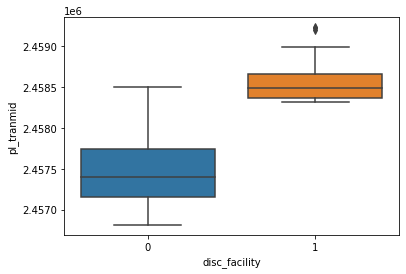

In [ ]:
#Visualizing the spread of the pl_tranmid feature between the K2/0 and TESS/1 exoplanets
sns.boxplot(data=modeling_df, x='disc_facility', y='pl_tranmid')

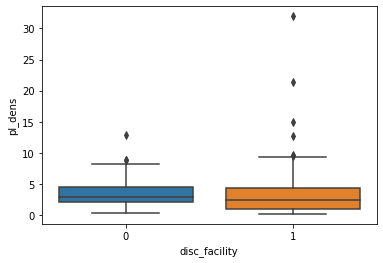

In [ ]:
sns.boxplot(data=modeling_df, x='disc_facility', y='pl_dens')

In [ ]:
#Try implementing a random forest classifier using the top 2 most
#important features, similar to our LR

train, test = train_test_split(modeling_df, test_size=0.3, random_state=0)

impt_top2 = ['pl_tranmid', 'pl_dens']
#define train, test sets
Y_train = train['disc_facility']
X_train = train[impt_top2]

Y_test = test['disc_facility']
X_test = test[impt_top2]

#normalize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

#predict
rf = RandomForestClassifier(random_state=0).fit(X_train, Y_train)
y_pred_train = rf.predict(X_train)

# on train data
print("Model Performance Metrics on Training data:")
accuracy,precision, recall, f1_score=model_metrics(Y_train, y_pred_train)
print('Accuracy score: ',accuracy)
print('recall: ', tpr)
print('precision: ', precision)
print('F1 Score: ',f1_score)

## on test data
y_pred = rf.predict(X_test)

print("Model Performance Metrics on Test data:")
accuracy,precision, recall, f1_score=model_metrics(Y_test, y_pred)
print('Accuracy score: ',accuracy)
print('recall: ', tpr)
print('precision: ', precision)
print('F1 Score: ',f1_score)

Model Performance Metrics on Training data:
Accuracy score:  1.0
recall:  1.0
precision:  1.0
F1 Score:  1.0
Model Performance Metrics on Test data:
Accuracy score:  1.0
recall:  1.0
precision:  1.0
F1 Score:  1.0


Text(0.5, 1.0, 'Confusion matrix for our final Random Forest Model.')

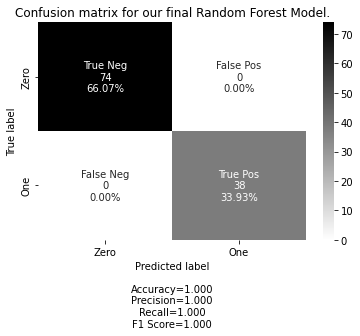

In [ ]:
#print the confusion matrix
cf_matrix=confusion_matrix(Y_test, y_pred)

# print(classification_report(Y_test, y_pred))

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')
plt.title('Confusion matrix for our final Random Forest Model')

Both our logistic regression and random forest classifier are performing really well. However, a higher performance/accuracy in the training data compared to the test data is a good indicator that there is overfitting in both models. We will address this in the cross validation part of the notebook.

###How do you perform cross validation on your model?

We're going to perform a k-fold cross validation to our model.

In [ ]:
top_features = top_features[:2]

In [ ]:
#Cross validation for the logistic regression model

X = modeling_df[top_features]
y = modeling_df['disc_facility']

#normalize
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = linear_model.LogisticRegression(random_state=0)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('scores: ' + '\t'.join([str(i) for i in scores]))
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

scores: 1.0	1.0	1.0	1.0	0.972972972972973	1.0	1.0	1.0	1.0	1.0
Accuracy: 0.997 (0.008)


In [ ]:
#Cross validation for the random classifier model

X = modeling_df[top_features]
y = modeling_df['disc_facility']

#normalize
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
# create model
model = RandomForestClassifier(random_state=0)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('scores: ' + '\t'.join([str(i) for i in scores]))
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

scores: 1.0	1.0	1.0	1.0	0.972972972972973	1.0	1.0	1.0	1.0	1.0
Accuracy: 0.997 (0.008)


Our model is doing really well because we have picked a feature that is a very good predictor.

###What loss metrics are you using to evaluate your model?

Since the target variables that we want to predict are binary, we use a simple loss metric using the prebuilt accuracy_score method from sklearn. This is essentially equivalent to using a mean absolute error (MAE) to measure our loss.

###From a bias-variance tradeoff standpoint, how do you assess the performance of your model? How do you check if it is overfitting?

If our training accuracy/performance does not exceed our testing accuracy/performance, this should be a good indicated that we are not over fitting our model.

In [ ]:
train, test = train_test_split(modeling_df, test_size=0.3, random_state=0)

#define train, test sets
Y_train = train['disc_facility']
X_train = train[top_features]

Y_test = test['disc_facility']
X_test = test[top_features]

#normalize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

# define the model
model = linear_model.LogisticRegression(random_state=0)

# estimate bias and variance
mse, bias, var = bias_variance_decomp(model, X_train, Y_train.values, X_test, Y_test.values, loss='mse', num_rounds=200, random_seed=1)

# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.001
Bias: 0.000
Variance: 0.001


In [ ]:
train, test = train_test_split(modeling_df, test_size=0.3, random_state=0)

#define train, test sets
Y_train = train['disc_facility']
X_train = train[top_features]

Y_test = test['disc_facility']
X_test = test[top_features]

#normalize
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

# define the model
model = RandomForestClassifier(random_state=0)

# estimate bias and variance
mse, bias, var = bias_variance_decomp(model, X_train, Y_train.values, X_test, Y_test.values, loss='mse', num_rounds=200, random_seed=1)

# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.005
Bias: 0.003
Variance: 0.002


From the analysis above we can see that our logistic regression model has a lower variance than our random forest classification, as expected but it also has surprisingly lower bias. This is interesting because linear models such as logistic regression tend to have high bias and low variance. From the cross validation section above, both logistic regression and random forest classification have the same mean accuracy when training with the top 2 features. So if judging from metrics such as MSE, Bias and Variance, the logistic regression model outperforms the random forest classifier. However, these values are so low that they are negligible.